## Import libraries

In [1]:
import gc
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Attention, Dropout
from tensorflow.keras.layers import Concatenate, Flatten
from tensorflow.keras.layers import Conv1D, Input, Dense
from tensorflow.keras.layers import Embedding, Activation
from tensorflow.keras.layers import LSTM, GRU, Bidirectional

## Prepare data for model training

In [2]:
train_df = pd.read_csv("../input/tabular-playground-series-jun-2021/train.csv")
train_df['target'] = train_df['target'].apply(lambda x: int(x.replace("Class_","")))
train_df['target'] = train_df['target'].apply(lambda x: 0 if x==9 else x)
train_df.set_index("id", inplace=True)
train_df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,target
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,6,1,0,0,0,0,7,0,...,0,0,0,0,0,0,2,0,0,6
1,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,1,0,6
2,0,0,0,0,0,1,0,3,0,0,...,0,0,0,0,1,0,0,0,0,2
3,0,0,7,0,1,5,2,2,0,1,...,0,4,0,2,2,0,4,3,0,8
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [3]:
test_df = pd.read_csv("../input/tabular-playground-series-jun-2021/test.csv")
test_df.set_index("id", inplace=True)
test_df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74
id,,,,,,,,,,,,,,,,,,,,,
200000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
200001,1,2,0,0,0,0,0,0,0,0,...,3,1,3,0,0,0,0,3,0,0
200002,0,1,7,1,0,0,0,0,6,0,...,3,0,0,0,0,3,0,2,0,0
200003,0,0,0,4,3,1,0,0,0,0,...,0,0,0,1,0,0,0,4,0,0
200004,0,0,5,0,0,0,0,0,0,8,...,0,0,0,0,0,0,0,0,1,0


In [4]:
Xtrain = train_df.loc[:, train_df.columns != 'target'].copy()
Ytrain = train_df['target'].copy()
Ytrain_oh = pd.get_dummies(train_df['target']).copy()
Xtest = test_df.copy()

print("Xtrain: {} \nYtrain: {} \nYtrain_oh: {} \nXtest: {}".format(Xtrain.shape, Ytrain.shape, 
                                                                   Ytrain_oh.shape, Xtest.shape))

del train_df
del test_df
gc.collect()

Xtrain: (200000, 75) 
Ytrain: (200000,) 
Ytrain_oh: (200000, 9) 
Xtest: (100000, 75)


62

## Define TPU config

In [5]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print("Running on TPU:", tpu.master())
    
except ValueError:
    strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")

Running on TPU: grpc://10.0.0.2:8470


In [6]:
mini_batch_size = strategy.num_replicas_in_sync * 32
print(f'batch size: {mini_batch_size}')

batch size: 256


## Build the models

In [7]:
def conv_lstm_model(n_features):
    
    x_input = Input(shape=(n_features,))
    
    embed = Embedding(input_dim=384, output_dim=8, 
                      embeddings_initializer='lecun_normal')(x_input)
    embed = LayerNormalization(epsilon=1e-5)(embed)
    
    x1 = Conv1D(filters=16, kernel_size=5, 
                strides=2, padding='same', 
                kernel_regularizer=l2(0.0003), 
                kernel_initializer='lecun_normal')(embed)
    x1 = LayerNormalization(epsilon=1e-5)(x1)
    x1 = Activation('relu')(x1)
    x1 = SpatialDropout1D(rate=0.2)(x1)
    
    x2 = Bidirectional(LSTM(units=16, activation='tanh',
                            return_sequences=True, dropout=0.15,
                            kernel_regularizer=l2(0.0001),
                            kernel_initializer='lecun_normal'), 
                      merge_mode='ave')(embed)
    x2 = LayerNormalization(epsilon=1e-5)(x2)
    
    x1 = Attention()([x1, x2])
    x1 = LayerNormalization(epsilon=1e-5)(x1)
    
    x1 = Flatten()(x1)
    x = Dropout(rate=0.2)(x1)
    
    x = Dense(units=32, kernel_initializer='lecun_normal', 
              kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu', name='Embedding1')(x)
    x = Dropout(rate=0.25)(x)
    
    x_output = Dense(units=9, activation='softmax', 
                     kernel_initializer='lecun_normal')(x)

    model = Model(inputs=x_input, outputs=x_output, 
                  name='CONV_LSTM_Model')
    return model

In [8]:
def lstm_gru_model(n_features):
    
    x_input = Input(shape=(n_features,))
    
    embed = Embedding(input_dim=384, output_dim=8, 
                      embeddings_initializer='lecun_normal')(x_input)
    embed = LayerNormalization(epsilon=1e-5)(embed)
    
    x1 = Bidirectional(LSTM(units=16, activation='tanh',
                            return_sequences=True, dropout=0.15,
                            kernel_regularizer=l2(0.0001),
                            kernel_initializer='lecun_normal'), 
                      merge_mode='ave')(embed)
    x1 = LayerNormalization(epsilon=1e-5)(x1)
    
    x2 = Bidirectional(GRU(units=16, activation='tanh',
                           return_sequences=True, dropout=0.15,
                           kernel_regularizer=l2(0.0001),
                           kernel_initializer='lecun_normal'),
                      merge_mode='ave')(embed)
    x2 = LayerNormalization(epsilon=1e-5)(x2)
    
    x1 = Attention()([x1, x2])
    x1 = LayerNormalization(epsilon=1e-5)(x1)
    
    x1 = Flatten()(x1)
    x = Dropout(rate=0.2)(x1)
    
    x = Dense(units=32, kernel_initializer='lecun_normal', 
                kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu', name='Embedding2')(x)
    x = Dropout(rate=0.15)(x)

    x_output = Dense(units=9, activation='softmax', 
                     kernel_initializer='lecun_normal')(x)
    
    model = Model(inputs=x_input, outputs=x_output, 
                  name='LSTM_GRU_Model')
    return model

In [9]:
class WeightedSum(tf.keras.layers.Layer):
    """A custom keras layer to learn a weighted sum of tensors"""
    
    def __init__(self, units=1, input_dim=1):
        super(WeightedSum, self).__init__()
        w_init = tf.random_normal_initializer()
        
        self.a = tf.Variable(
            initial_value=w_init(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, model_outputs):
        return tf.multiply(model_outputs[0], self.a) + tf.multiply(model_outputs[1], (1 - self.a))

In [10]:
model1 = conv_lstm_model(Xtrain.shape[1])
model2 = lstm_gru_model(Xtrain.shape[1])

x = WeightedSum()([model1.get_layer('Embedding1').output, 
                   model2.get_layer('Embedding2').output])

x_output = Dense(units=9, activation='softmax', 
                 kernel_initializer='lecun_normal')(x)

model = Model([model1.input, model2.input], x_output, 
              name='CLRP_Pina_Colada_Model')
model.summary()

Model: "CLRP_Pina_Colada_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 75, 8)        3072        input_1[0][0]                    
__________________________________________________________________________________________________
layer_normalization (LayerNorma (None, 75, 8)        16          embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 75)]         0                                            
_____________________________________________________________________________

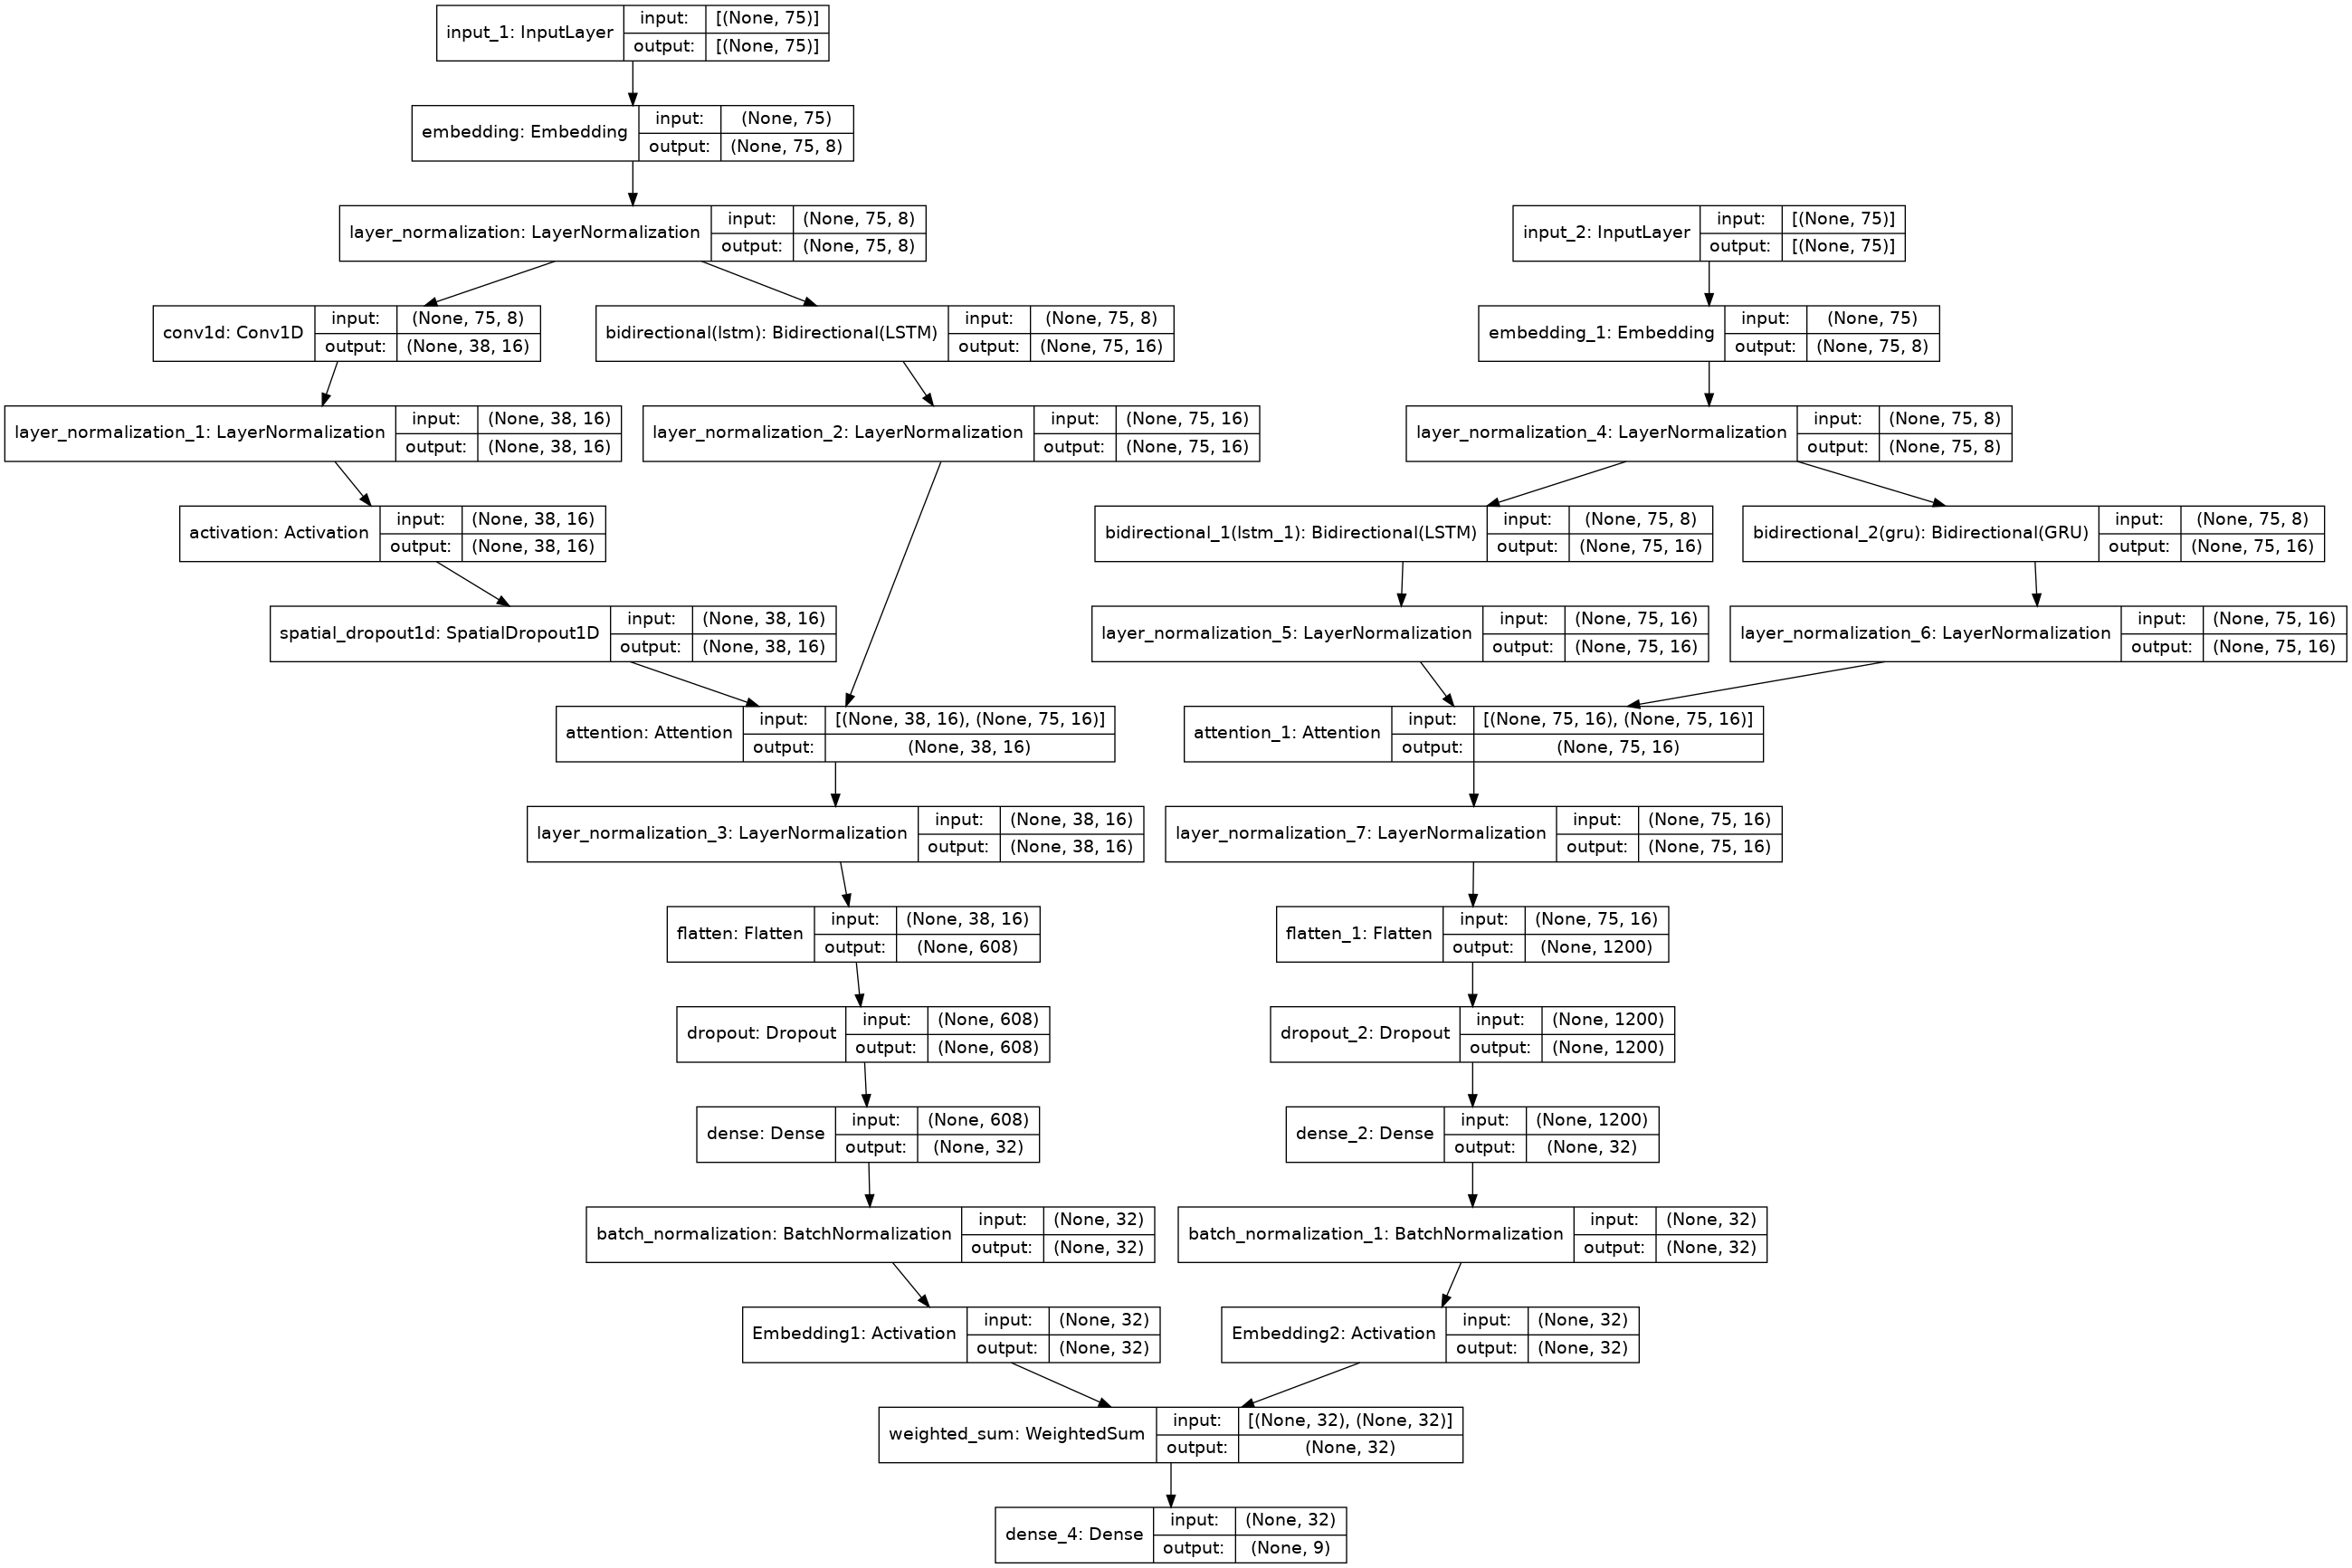

In [11]:
plot_model(
    model, to_file='./CLRP_Pina_Colada_Model.png', 
    show_shapes=True, show_layer_names=True
)

In [12]:
FOLD = 20
NUM_SEED = 2
VERBOSE = 0

np.random.seed(47)
seeds = np.random.randint(0, 100, size=NUM_SEED)

counter = 0
oof_score = 0
y_pred_meta_dnn = np.zeros((Xtrain.shape[0], 9))
y_pred_final_dnn = np.zeros((Xtest.shape[0], 9))

In [13]:
with strategy.scope():
    
    for sidx, seed in enumerate(seeds):
        seed_score = 0
        seed_counter = 0

        kfold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed)

        for idx, (train, val) in enumerate(kfold.split(Xtrain, Ytrain)):
            counter += 1
            seed_counter += 1

            train_x, train_y, train_y_oh = Xtrain.iloc[train], Ytrain.iloc[train], Ytrain_oh.iloc[train]
            val_x, val_y, val_y_oh = Xtrain.iloc[val], Ytrain.iloc[val], Ytrain_oh.iloc[val]
            
            tf.random.set_seed(seed+idx)
            
            #===========================================================================
            #                            Load CONV-LSTM Model
            #===========================================================================
            
            model1 = conv_lstm_model(Xtrain.shape[1])
            model1.trainable = False

            for layer in model1.layers[-5:]:
                if not isinstance(layer, BatchNormalization):
                    layer.trainable = True
            
            model1.load_weights(f'../input/tps-june-mojito/CONV_LSTM_Model_{seed_counter}C.h5')
            
            #===========================================================================
            #                             Load LSTM-GRU Model
            #===========================================================================
            model2 = lstm_gru_model(Xtrain.shape[1])
            model2.trainable = False

            for layer in model2.layers[-5:]:
                if not isinstance(layer, BatchNormalization):
                    layer.trainable = True
            
            model2.load_weights(f'../input/tps-june-mojito/LSTM_GRU_Model_{seed_counter}C.h5')
            
            #===========================================================================
            #                             Build ensemble model
            #===========================================================================
            
            x = WeightedSum()([model1.get_layer('Embedding1').output, 
                               model2.get_layer('Embedding2').output])
            x = Dropout(rate=0.25)(x)

            x_output = Dense(units=9, activation='softmax', 
                             kernel_initializer='lecun_normal')(x)

            model = Model([model1.input, model2.input], x_output, 
                          name='CLRP_Pina_Colada_Model')
            
            model.compile(loss='categorical_crossentropy',
                          optimizer=Adamax(lr=1e-3))

            early = EarlyStopping(monitor="val_loss", mode="min", 
                                  restore_best_weights=True, 
                                  patience=7, verbose=VERBOSE)

            reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.25, 
                                          min_lr=1e-6, patience=3, 
                                          verbose=VERBOSE, mode='min')

            chk_point = ModelCheckpoint(f'./CLRP_Pina_Colada_Model_{counter}C.h5', 
                                        monitor='val_loss', verbose=VERBOSE, 
                                        save_best_only=True, mode='min', 
                                        save_weights_only=True)

            history = model.fit(
                [train_x, train_x], train_y_oh, 
                batch_size=mini_batch_size,
                epochs=150, 
                verbose=VERBOSE, 
                callbacks=[reduce_lr, early, chk_point], 
                validation_data=([val_x, val_x], val_y_oh)
            )

            model.load_weights(f'./CLRP_Pina_Colada_Model_{counter}C.h5')
            
            y_pred = model.predict([val_x, val_x])
            y_pred_meta_dnn[val] += y_pred
            y_pred_final_dnn += model.predict([Xtest, Xtest])

            score = log_loss(val_y_oh, y_pred)
            oof_score += score
            seed_score += score
            print("Seed-{} | Fold-{} | OOF Score: {}\n".format(seed, idx, score))
            
        print("Seed: {} | Aggregate OOF Score: {}\n\n".format(seed, (seed_score / FOLD)))

Seed-7 | Fold-0 | OOF Score: 1.7405380190487019

Seed-7 | Fold-1 | OOF Score: 1.7371166871686465

Seed-7 | Fold-2 | OOF Score: 1.7409610201755539

Seed-7 | Fold-3 | OOF Score: 1.7424080985548906

Seed-7 | Fold-4 | OOF Score: 1.740914580976218

Seed-7 | Fold-5 | OOF Score: 1.74236853653118

Seed-7 | Fold-6 | OOF Score: 1.7400795814016834

Seed-7 | Fold-7 | OOF Score: 1.7364345508905128

Seed-7 | Fold-8 | OOF Score: 1.7501907616561279

Seed-7 | Fold-9 | OOF Score: 1.7436454585833474

Seed-7 | Fold-10 | OOF Score: 1.7450644876377657

Seed-7 | Fold-11 | OOF Score: 1.7351833597239106

Seed-7 | Fold-12 | OOF Score: 1.7341660984762013

Seed-7 | Fold-13 | OOF Score: 1.7426524886019528

Seed-7 | Fold-14 | OOF Score: 1.7364543522041291

Seed-7 | Fold-15 | OOF Score: 1.7406511002128944

Seed-7 | Fold-16 | OOF Score: 1.7343199090350419

Seed-7 | Fold-17 | OOF Score: 1.7424134780514986

Seed-7 | Fold-18 | OOF Score: 1.7402800674505532

Seed-7 | Fold-19 | OOF Score: 1.7285616423312575

Seed: 7 | Agg

In [14]:
y_pred_meta_dnn = y_pred_meta_dnn / float(NUM_SEED)
y_pred_final_dnn = y_pred_final_dnn / float(counter)
oof_score /= float(counter)
print("Aggregate OOF Score: {}".format(oof_score))

Aggregate OOF Score: 1.7397229844624345


In [15]:
np.savez_compressed('./CLRP_Pina_Colada_Meta_Features.npz',
                    y_pred_meta_dnn=y_pred_meta_dnn, 
                    oof_score=oof_score,
                    y_pred_final_dnn=y_pred_final_dnn)

## Create submission file

In [16]:
test_df = pd.read_csv("../input/tabular-playground-series-jun-2021/test.csv")
submit_df = pd.DataFrame()
submit_df['id'] = test_df['id']
submit_df['Class_1'] = y_pred_final_dnn[:,1]
submit_df['Class_2'] = y_pred_final_dnn[:,2]
submit_df['Class_3'] = y_pred_final_dnn[:,3]
submit_df['Class_4'] = y_pred_final_dnn[:,4]
submit_df['Class_5'] = y_pred_final_dnn[:,5]
submit_df['Class_6'] = y_pred_final_dnn[:,6]
submit_df['Class_7'] = y_pred_final_dnn[:,7]
submit_df['Class_8'] = y_pred_final_dnn[:,8]
submit_df['Class_9'] = y_pred_final_dnn[:,0]
submit_df.to_csv("./Pina_Colada_Submission.csv", index=False)
submit_df.head()

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,200000,0.069519,0.430631,0.158788,0.026267,0.013407,0.132045,0.019362,0.037794,0.112188
1,200001,0.043089,0.068590,0.052376,0.021004,0.014525,0.270660,0.088915,0.313972,0.126868
2,200002,0.017295,0.024587,0.017861,0.009515,0.005325,0.751645,0.025998,0.103285,0.044487
3,200003,0.049720,0.128835,0.092440,0.035451,0.022563,0.223649,0.078330,0.211284,0.157728
4,200004,0.042702,0.114951,0.082941,0.024806,0.014451,0.272382,0.070502,0.228075,0.149191
